# Standard Genetic Programming Algorithm

In this assignment we are going to explore the symbolic regression using Genetic Programming. The idea of symbolic regression is to discover a mathematical expression or equation that best represents the underlying relationship between variables in a dataset. This involves finding a balance between accuracy, i.e. fitting the data well, and simplicity, i.e. ensuring the expression is interpretable and generalizes to new data. We will be doing symbolic regression resorting to tree based Genetic Programming, an evolutionary algorithm type as you learn in class. The problem at hand is to create a mathematical expression that minimizes the error between the predicted values and the observed data points in the given dataset.

## Assignment Task (MUST READ)

1. Analyse the implementations bellow for symbolic regression using Genetic Programming. The code is ready to run on one dataset (datasetSimple).

2. Implement the following:
- 2.1 Only a simple base of terminals and functions are implemented. Expand by implementing other functions and terminals that you see fit for the problem. Do some trial runs to test and validate your expanded set, however create and choose at most **one more set** of terminals and functions for points 3. and 4. .
- 2.2 Add the elitism mechanism.
- 2.3 Implement and add the point mutation operator. The idea is to have a probability of using either subtree mutaton or point mutation during the mutation operation.
- 2.4 Create a fitness function with bloat control.

3. Run experiments on **datasetSimple** and **datasetHard** and analyse the following setups:
- 3.1 elistism **vs** no elitism 
- 3.2 simple terminals and functions **vs** implemented expanded set of functions and terminals.
- 3.4 normal fitness function **vs** fitness function with bloat control.

Note: for all experiments run **5 different random seeds**

4. Analyse the results from the experiments by reporting in this notebook. The analysis for each experiment should take into account:
- 4.1 best fitness value, but provide the plot generation/fitness (x/y)
- 4.2 number of generations needed to reach the minimum aceptable error value (<= 1e-6) . Note that different seeds or configurations can terminate before the defined number o generations.
- 4.3 the size of the three (number of nodes) and depth.


In the end, you should indicate the best setup that you found for each dataset.

Note: Resort to the tehoretical slides and like in the first assignment, in order to analyse and draw conclusions you **must run the same setup multiple times with different random seeds**.

Further reading:

Field guide to Genetic Programming: http://www0.cs.ucl.ac.uk/staff/W.Langdon/ftp/papers/poli08_fieldguide.pdf


### CODE

In [328]:
# Adaptation of the Tiny-GP code available at https://github.com/moshesipper/tiny_gp/blob/master/tiny_gp.py
from random import random, randint, seed, sample
from statistics import mean
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math

# Definition of the Terminal and Non-Terminal Symbols
In this section, you are expected to define terminal and non-terminal (functions) symbols of the Genetic Programming approach. Some of them are already defined.


In [329]:
# TODO update and add code here
# ---------------------------
# Function Definitions
# ---------------------------


def add(x, y):
    return x + y


add.arity = 2


def sub(x, y):
    return x - y


sub.arity = 2


def mul(x, y):
    return x * y


mul.arity = 2


def log_base(x, y):
    if x <= 0:
        return -1
    elif y <= 1:
        return -1
    else:
        return math.log(x, y)


log_base.arity = 2


def div(x, y):
    if y == 0:
        return -1
    else:
        return x / y


div.arity = 2


def sqrt_f(x):
    if x < 0:
        return -1
    else:
        return x**0.5


sqrt_f.arity = 1


def abs_f(x):
    return abs(x)


abs_f.arity = 1


def square(x):
    return x**2


square.arity = 1


def exp_f(x):
    return math.exp(x)


exp_f.arity = 1


# ---------------------------
# Terminals and Function List
# ---------------------------
TERMINALS = ["x", -3, -2, -1, -0.5, 0, 0.5, 1, 2, 3]
FUNCTIONS = [add, sub, mul, abs_f, sqrt_f, div, log_base, square]

# expanded set
# EXPANDED_FUNCTIONS = [...]
# EXPANDED_TERMINALS = [...]

FUNCTIONS = FUNCTIONS  # EXPANDED_FUNCTIONS
TERMINALS = TERMINALS  # EXPANDED_TERMINALS

# Parameters

These are the base evolutionary parameters. 

In [330]:
POP_SIZE        = 100   # population size
MIN_DEPTH       = 3    # minimal initial random tree depth
MAX_DEPTH       = 8   # maximal initial random tree depth
GENERATIONS     = 500  # maximal number of generations to run evolution
TOURNAMENT_SIZE = 15    # size of tournament for tournament selection
XO_RATE         = 0.8  # crossover rate 
PROB_MUTATION   = 0.2  # per-node mutation probability 
ELITISM = 0.1 #0

# Representation of a Program using a GP Tree
Analyze the following code. This is the base code, and some parts will require updates to fulfill the assignment.

In [331]:
import random
from random import randint, random

class GPTree:
    def __init__(self, data=None, children=None):
        self.data = data
        # Use a list for children; if not provided, initialize as empty.
        self.children = children if children is not None else []

    def node_label(self):
        if self.data in FUNCTIONS:
            return self.data.__name__
        else:
            return str(self.data)

    def print_tree(self, prefix=""):
        print(f"{prefix}{self.node_label()}")
        for child in self.children:
            child.print_tree(prefix + "   ")

    def compute_tree(self, x):
        # If the node holds a function, compute all its children first.
        if self.data in FUNCTIONS:
            args = [child.compute_tree(x) for child in self.children]
            return self.data(*args)
        elif self.data == 'x':
            return x
        else:
            return self.data

    def random_tree(self, grow, max_depth, depth=0):
        # Decide whether this node will be a function or a terminal.
        if depth < MIN_DEPTH or (depth < max_depth and not grow):
            self.data = FUNCTIONS[randint(0, len(FUNCTIONS) - 1)]
        elif depth >= max_depth:
            self.data = TERMINALS[randint(0, len(TERMINALS) - 1)]
        else:
            if random() > 0.5:
                self.data = TERMINALS[randint(0, len(TERMINALS) - 1)]
            else:
                self.data = FUNCTIONS[randint(0, len(FUNCTIONS) - 1)]
        # If the node is a function, create as many children as its arity
        if self.data in FUNCTIONS:
            self.children = []
            for _ in range(self.data.arity):
                child = GPTree()
                child.random_tree(grow, max_depth, depth + 1)
                self.children.append(child)

    def mutation(self):
        if random() < PROB_MUTATION:
            # Replace this subtree with a new random tree (of limited depth)
            self.random_tree(grow=True, max_depth=2)
        else:
            for child in self.children:
                child.mutation()

    def size(self):
        if self.data not in FUNCTIONS:
            return 1
        return 1 + sum(child.size() for child in self.children)

    def build_subtree(self):
        t = GPTree()
        t.data = self.data
        t.children = [child.build_subtree() for child in self.children]
        return t

    def scan_tree(self, count, second):
        count[0] -= 1
        if count[0] <= 1:
            if not second:
                return self.build_subtree()
            else:
                self.data = second.data
                self.children = second.children
        else:
            ret = None
            for child in self.children:
                if count[0] > 1:
                    ret = child.scan_tree(count, second)
            return ret

    def crossover(self, other):
        if random() < XO_RATE:
            second = other.scan_tree([randint(1, other.size())], None)
            self.scan_tree([randint(1, self.size())], second)


# Fitness Evaluation
You have to adjust this code in order to introduce bloat control mechanism. You should maintain the version without bloat control for comparison.

In [332]:
# *** YOUR CODE HERE ***
# You are going to need to add another function in order to introduce a bloat control mechanism. Adapt the existing one.
def calculate_error(individual, dataset):
    return mean([abs(individual.compute_tree(ds[0]) - ds[1]) for ds in dataset])


def fitness(
    individual, dataset, bloat_control=False
):  # mean absolute error over dataset normalized to [0,1]
    error = calculate_error(individual, dataset)

    if not bloat_control:
        return error

    individual_size = individual.size()
    
    return error + ((0.05 * individual_size) * error)

# Parent Selection
The selection mechanism implemented is the tournament selection.

In [333]:
def selection(population, fitnesses): # select one individual using tournament selection
    tournament = [randint(0, len(population)-1) for i in range(TOURNAMENT_SIZE)] # select tournament contenders
    tournament_fitnesses = [fitnesses[tournament[i]] for i in range(TOURNAMENT_SIZE)]
    return deepcopy(population[tournament[tournament_fitnesses.index(min(tournament_fitnesses))]]) 

# Survivor Selection
The implementation of elistism should be done here, check the code, follow the instructions and complete the code.

In [334]:
def survivors_selection_elite(parents, fitnesses, offspring, elite):
    # This Function Should then be called in the Main Cycle line 23, i.e. it should replace the generational mechanism that is currectly in place
    size = len(parents)
    elite_size = int(size * elite)
    new_population = []
    
    # sort fitnesses ascending
    sorted_fitnesses = np.argsort(fitnesses)
    # add elite to new population
    elite_pop = [parents[i] for i in sorted_fitnesses[:elite_size]]
    
    new_population.extend(elite_pop)
    
    #sample from offspring
    offspring_size = size - elite_size
    offspring_sample = sample(offspring, offspring_size)
    new_population.extend(offspring_sample)

    return new_population

# Generate Inital Population using Ramped Half-and-Half
Ramped half-and-half is a method for initializing populations, where half of the individuals are generated using a "full" method (producing complete trees up to a specified depth), and the other half are created using a "grow" method (producing trees of varying shapes and depths), ensuring diversity in the initial population.

In [335]:
# Generate an individual: method full or grow
# Field Guide Genetic Programming: algorithm 2.1, pg.14
def init_population():
    pop = []
    for md in range(3, MAX_DEPTH + 1):
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = True, max_depth = md) # grow
            pop.append(t) 
        for i in range(int(POP_SIZE/6)):
            t = GPTree()
            t.random_tree(grow = False, max_depth = md) # full
            pop.append(t)
    #If we are missing some inviduals, just fill the rest of population with random trees with the full method
    print(len(pop))
    if len(pop) < POP_SIZE: 
        for i in range(POP_SIZE - len(pop)):
            t = GPTree()
            t.random_tree(grow = False, max_depth = md) # full
            pop.append(t)
    elif len(pop) > POP_SIZE:
        pop = pop[:POP_SIZE]
    
    print(len(pop))
    return pop

# Main Cycle

In [336]:
def standard_gp(dataset, verbose=False):
    # init stuff
    seed()  # init internal state of random number generator
    population = init_population()
    best_of_run = None
    best_of_run_f = 999999.0
    best_of_run_gen = 999999.0
    best_per_generation = []
    fitnesses = [fitness(population[i], dataset, bloat_control=True) for i in range(POP_SIZE)]

    # go evolution!
    for gen in range(GENERATIONS):
        if verbose:
            print("Generation: %d" % gen)
        nextgen_population = []
        for i in range(POP_SIZE):
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)
            parent1.crossover(parent2)
            parent1.mutation()
            nextgen_population.append(parent1)

        # Generational Strategy
        population = survivors_selection_elite(
            population, fitnesses, nextgen_population, ELITISM
        )
        fitnesses = [fitness(population[i], dataset,bloat_control=True) for i in range(POP_SIZE)]
        best_per_generation.append(min(fitnesses))

        # Elitism

        if min(fitnesses) < best_of_run_f:
            best_of_run_f = min(fitnesses)
            best_of_run_gen = gen
            best_of_run = deepcopy(population[fitnesses.index(min(fitnesses))])
            if verbose:
                print("________________________")
                print(
                    "gen:",
                    gen,
                    ", best_of_run_f:",
                    round(min(fitnesses), 3),
                    ", best_of_run:",
                )
                best_of_run.print_tree()
        if best_of_run_f <= 1e-6:
            break

    if verbose:
        print(
            "\n\n_________________________________________________\nEND OF RUN\nbest_of_run attained at gen "
            + str(best_of_run_gen)
            + " and has f="
            + str(round(best_of_run_f, 3))
        )
        best_of_run.print_tree()
    return best_per_generation, best_of_run

# Load DataSet

In [337]:
def load_dataset(file_name):
    from numpy import genfromtxt
    my_data = genfromtxt(file_name, delimiter=',')
    return my_data

In [338]:
dataset = load_dataset('datasetHard.csv')
print(dataset)

[[-1.         -0.15852902]
 [-0.97979798 -0.09022457]
 [-0.95959596 -0.02505046]
 [-0.93939394  0.03706251]
 [-0.91919192  0.09618287]
 [-0.8989899   0.15237845]
 [-0.87878788  0.20571648]
 [-0.85858586  0.25626368]
 [-0.83838384  0.30408621]
 [-0.81818182  0.34924981]
 [-0.7979798   0.39181978]
 [-0.77777778  0.43186103]
 [-0.75757576  0.46943809]
 [-0.73737374  0.50461519]
 [-0.71717172  0.53745624]
 [-0.6969697   0.56802487]
 [-0.67676768  0.59638445]
 [-0.65656566  0.6225981 ]
 [-0.63636364  0.64672874]
 [-0.61616162  0.66883906]
 [-0.5959596   0.68899158]
 [-0.57575758  0.70724864]
 [-0.55555556  0.7236724 ]
 [-0.53535354  0.73832489]
 [-0.51515152  0.75126798]
 [-0.49494949  0.76256341]
 [-0.47474747  0.77227281]
 [-0.45454545  0.78045769]
 [-0.43434343  0.78717944]
 [-0.41414141  0.79249935]
 [-0.39393939  0.79647863]
 [-0.37373737  0.79917837]
 [-0.35353535  0.80065961]
 [-0.33333333  0.80098328]
 [-0.31313131  0.80021025]
 [-0.29292929  0.79840129]
 [-0.27272727  0.79561711]
 

In [339]:
best_by_generation, overall_best = standard_gp(dataset, verbose=True)

192
100
Generation: 0
________________________
gen: 0 , best_of_run_f: 0.207 , best_of_run:
abs_f
   square
      sqrt_f
         sqrt_f
            0.5
Generation: 1
________________________
gen: 1 , best_of_run_f: 0.182 , best_of_run:
sqrt_f
   0.5
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generat

In [340]:
overall_best.print_tree()
erro = calculate_error(overall_best,dataset)
print(erro)
print(((0.05 * overall_best.size()) * erro) )

sqrt_f
   0.5
0.16588136999438743
0.016588136999438743


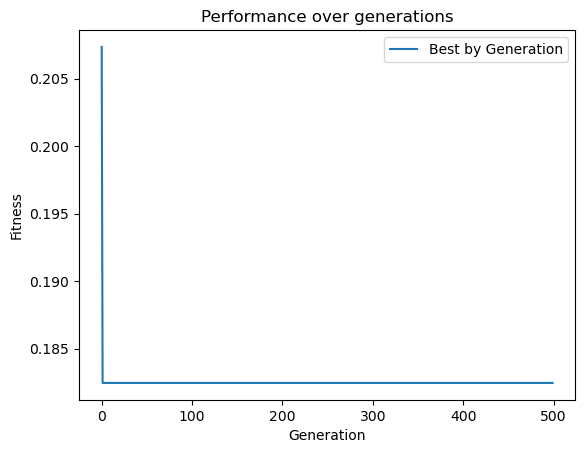

In [341]:
generations = list(range(len(best_by_generation)))
plt.plot(generations, best_by_generation, label='Best by Generation')
plt.title('Performance over generations')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend(loc='best')
plt.show()